My goal is create machine learning model for credit card fraud transactions detector.
Tasks:
1. Load dataset
2. Analyse data to define preprocessing work
3. Preprocess data, create trainig and test sets
4. Try different ML algorithms and evaluate them
5. Choose best model

In [54]:
# load all necessary libraries
import pandas as pd
import keras
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB as NB
from xgboost import XGBClassifier as XGBC

from scitime import Estimator

from keras import models
from keras import layers

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [2]:
# define function to draw heatmap, because that instrument helps us further along project
def draw_corr_heatmap(df):
    '''function gets dataframe and draw corelation heatmap'''
    # create correlation table with absolute values
    # we don't care is are there positive or negative correlation
    corr_table = df.corr().abs()
    # create triangle mask
    # it increase readability
    mask = np.triu(corr_table)
    # define figure size
    plt.figure(figsize=(20, 20))
    # create heatmap
    sns.heatmap(corr_table,
                annot=True,
                fmt='.1g',
                vmin=0,
                vmax=1,
                center=0.5,
                cmap='coolwarm',
                square=True,
                mask=mask
               )

In [3]:
# load the data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


What we can see from dataframe is that most of the features are nameless. Fraud detection is a classification problem. From the description 0 in 'Class' column means odinary transaction and 1 - fraudulent transaction.

First of all I want to check whether we have missing values and to know the number of records

In [4]:
print(f'number of records is {df.shape[0]}')

number of records is 284807


In [5]:
df.count()

Time      284807
V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
V6        284807
V7        284807
V8        284807
V9        284807
V10       284807
V11       284807
V12       284807
V13       284807
V14       284807
V15       284807
V16       284807
V17       284807
V18       284807
V19       284807
V20       284807
V21       284807
V22       284807
V23       284807
V24       284807
V25       284807
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
dtype: int64

As we can see there are no missing data, that's good

Now let's look at the type of data. By first look it seems that all features are numerical, but I want to be certain that there are no categorical data

In [68]:
# create empty list for data types
data_types = []
# run through every column
for i in range(len(df.columns)):
    # save data type of the current column
    t = df.iloc[:, i].dtype.name
    # append it to the list
    data_types.append(t)

# view data types
data_types

['float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'float64',
 'int64']

Alright, next step check the distribution of classes

In [4]:
# see number of frauds in data
df[df['Class'] == 1].shape

(492, 31)

In [5]:
# see number of normal operations
df[df['Class'] == 0].shape

(284315, 31)

As we can see classes a highly imbalanced and that can be a big problem which we must handle

I assume that 'Time' column might be excess in terms of learning and it doesn't carry any vital information, so I just drop it from dataframe

<AxesSubplot:ylabel='Time'>

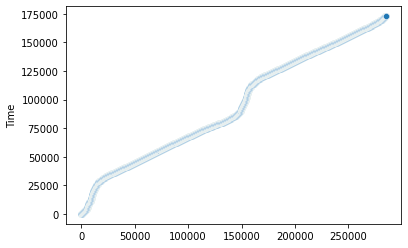

In [6]:
sns.scatterplot(df.index, df['Time'])

In [7]:
# drop 'Time' column from main dataframe
df = df.drop(['Time'], axis=1)

Now before we go further let's check how features are correlated between each other, because multicollinearity may cause problems during learning and leads to poor quality models

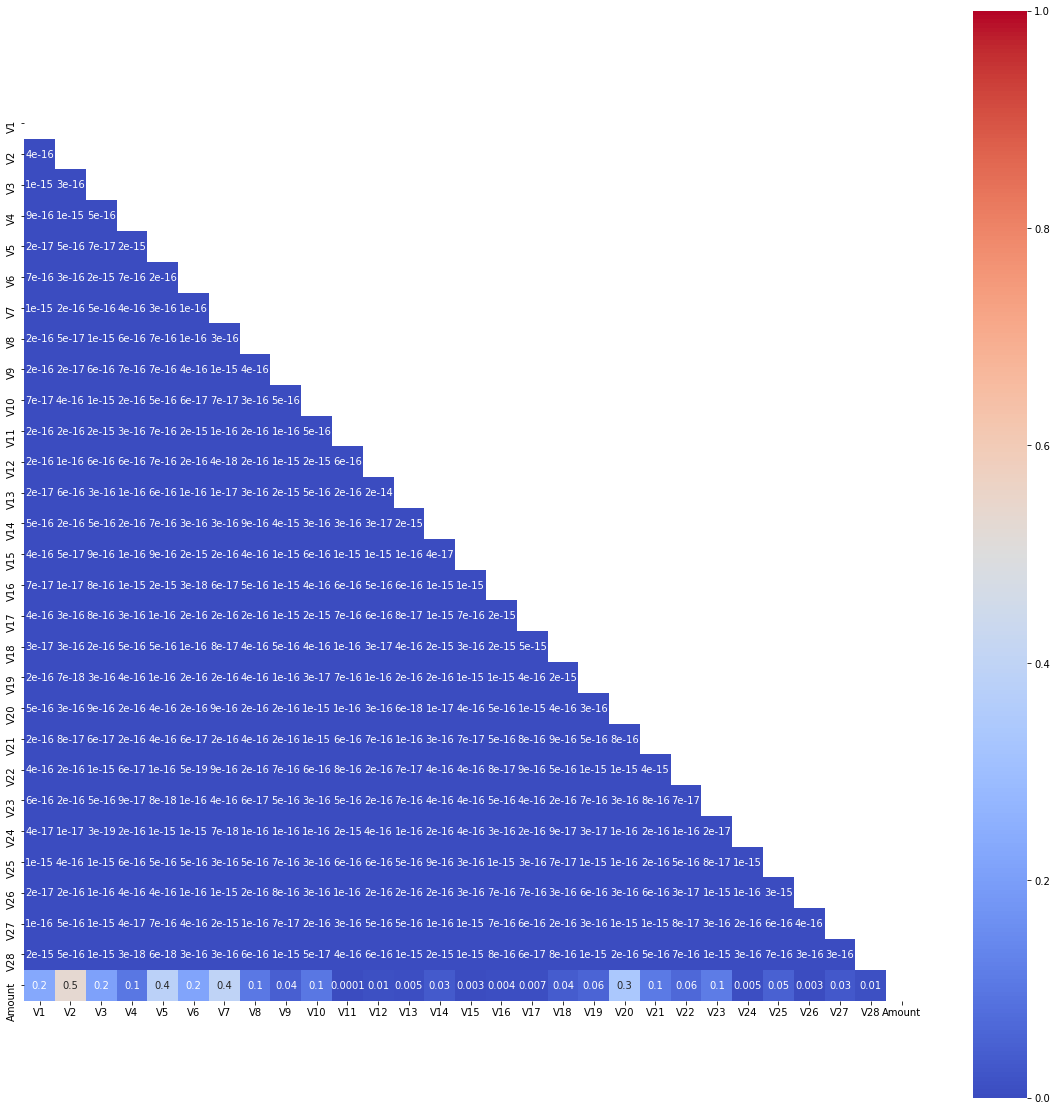

In [8]:
# select features from dataframe
features = df.drop(['Class'], axis=1)
# and make a target vector
target = df['Class']
# draw correlation heatmap
draw_corr_heatmap(features)

There is almost no corellation at all, that is good

A very important step check data for outliers. For sake of readability I scale data and draw a boxplot.

<AxesSubplot:>

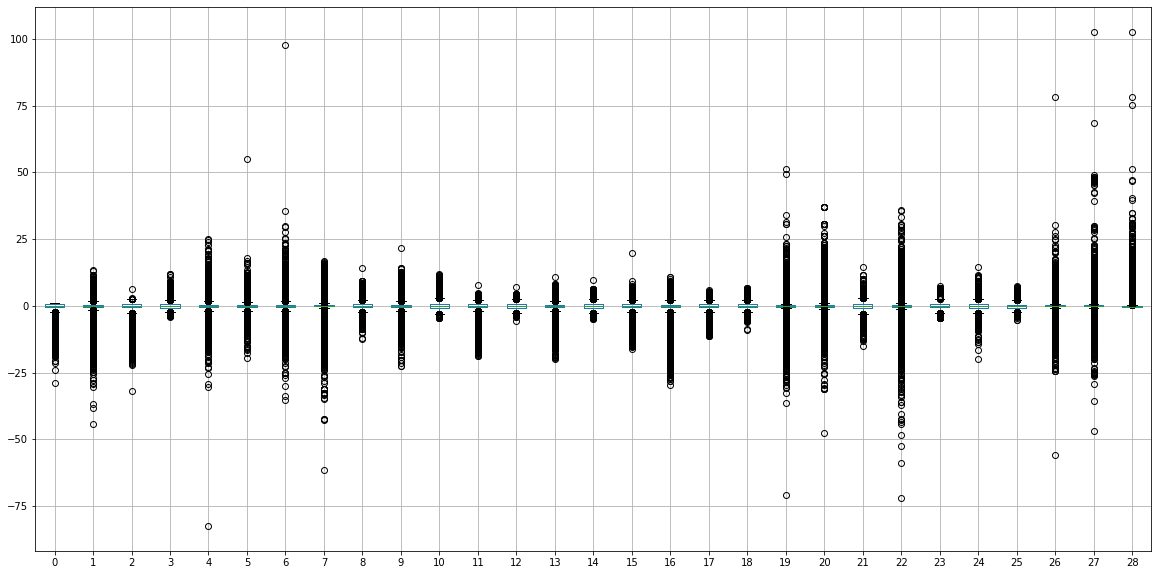

In [9]:
# create scaler
scaler = StandardScaler()
# scale features
scaled_features = scaler.fit_transform(features)
# scaler return ndarray
# transform it to dataframe
scaled_features = pd.DataFrame(scaled_features)
# draw boxplot
scaled_features.boxplot(figsize=(20, 10))

As we can see there are a lot of outliers, but at first look I can't decide whether I should delete them or not.

Let's use a technique of defining outliers called z-score, asume that z=3 and look how many outliers we find.

We will work with scaled features

In [10]:
scaled_features[(scaled_features.abs() > 3).any(axis=1)].shape

(37816, 29)

There is ~38k outliers, problem is that among them there are may be frauds and we don't want to delete them

Before remove outliers (if we want to remove them), we should split our dataframe into training and test sets and remove outliers only in training set

In [11]:
# make train and test sets
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.33, 
                                                                            stratify=target
                                                                           )

We already can use train features and target to build ML models

One last problem is imbalance of classes. There are many techniques to handle this problem, we may use an odinary oversampling, but I prefer to use SMOTE algorithm.

In [12]:
# resampled dataset using SMOTE algorithm
sm = SMOTE()
train_features_smote, train_target_smote = sm.fit_resample(X=train_features, y=train_target)

That technique also have a little catch. Lets look at correlation heatmap of our new train features

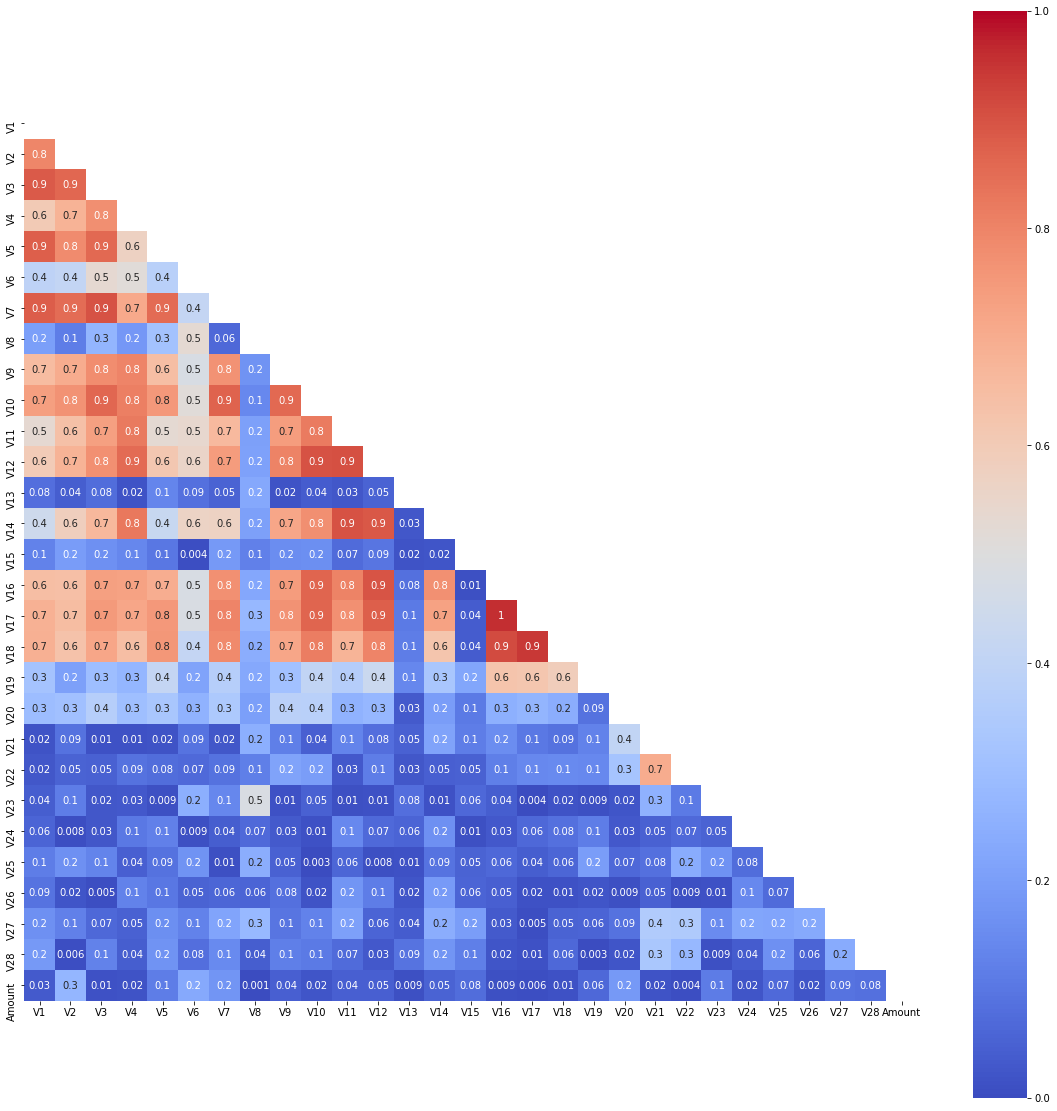

In [13]:
draw_corr_heatmap(train_features_smote)

Unfortunately, correlation between features increased a lot. This is explained by oversampling and SMOTE algorithm, we create almost 100k new samples based on original 500. But this is not a big problem

Further during trainig our models we include dimensiality reduction with PCA algorithm. Let's see how it will work

In [14]:
# scale features
features_std = StandardScaler().fit_transform(train_features_smote)
# create PCA which will remain 99% of explained variance
pca = PCA(n_components=0.99) 
features_pca = pca.fit_transform(features_std)
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_pca.shape[1])

Original number of features: 29
Reduced number of features: 23


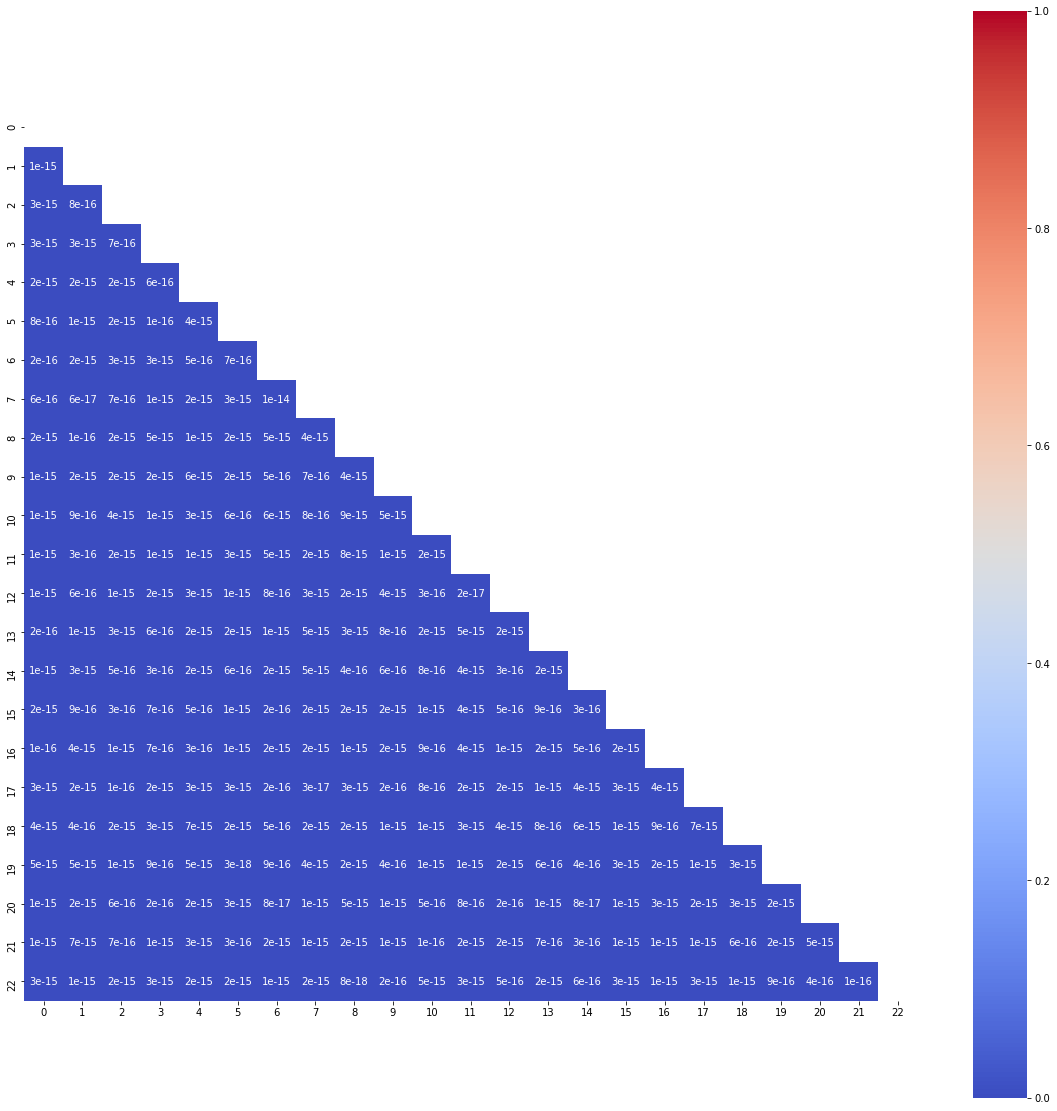

In [15]:
draw_corr_heatmap(pd.DataFrame(features_pca))

Now we have train_features_smote and train_target_smote. Outliers are present in them. Let's create another training dataset with removed outliers. We can try different z values and evaluate models quality 

In [16]:
# write function that removes outliers using given z-score
def remove_outliers(train_features, train_target, Z=3):
    # create train dataframe
    train_df = train_features
    train_df['Class'] = train_target
    # find frauds
    frauds = train_df[train_df['Class']==1]
    frauds_indicies = frauds.index
    # create dataframe without frauds
    df_no_frauds = train_df.drop(frauds_indicies)
    # separate features from dataframe
    no_frauds_features = df_no_frauds.drop(['Class'], axis=1)
    # scale features
    scaler = StandardScaler()
    scaled_nf_features = scaler.fit_transform(no_frauds_features)
    # and transform ndarray to dataframe
    scaled_nf_features = pd.DataFrame(scaled_nf_features, 
                                      columns=train_features.drop(['Class'], axis=1).columns, 
                                      index=df_no_frauds.drop(['Class'], axis=1).index)
    # remove from dataframe without frauds every sample if at least one feature is an outlier
    # for that compare every column with Z
    df_nf_no_outliers = df_no_frauds[~(scaled_nf_features.abs() > Z).any(axis=1)]
    # now concatenate df_nf_no_outliers with frauds and we get our final dataframe
    pure_df = pd.concat([df_nf_no_outliers, frauds])
    pure_features = pure_df.drop(['Class'], axis=1)
    pure_target = pure_df['Class']
    return pure_features, pure_target

In [17]:
# create a few different training sets
train_features_z3, train_target_z3 = remove_outliers(train_features, train_target, 3)
train_features_z5, train_target_z5 = remove_outliers(train_features, train_target, 5)
train_features_z7, train_target_z7 = remove_outliers(train_features, train_target, 7)
train_features_z9, train_target_z9 = remove_outliers(train_features, train_target, 9)
# and use smote algorithm
train_features_smote_z3, train_target_smote_z3 = sm.fit_resample(X=train_features_z3, y=train_target_z3)
train_features_smote_z5, train_target_smote_z5 = sm.fit_resample(X=train_features_z5, y=train_target_z5)
train_features_smote_z7, train_target_smote_z7 = sm.fit_resample(X=train_features_z7, y=train_target_z7)
train_features_smote_z9, train_target_smote_z9 = sm.fit_resample(X=train_features_z9, y=train_target_z9)

Before we start to implement and evaluate algorithms I want to outline some things:
1. We try three diferent algorithms: Logistic Regression, RandomForest and XGBoost
2. For each algorithm there is the same pipeline: standardize data -> reduce dimensionality -> implement algorithm
3. For tuning model we use GridSearch with cross-validation
4. As a evaluation metric I consider to pick recall (or maybe f1-score or roc_auc) because in my opinion in this problem more important to find as many frauds as posible and we can afford incorrect classification of normal transaction as a fraudulent

# Logistic Regression

In [18]:
# create pipeline and grid search
steps = [('scaler', StandardScaler()), # standardize data
         ('pca', PCA(n_components=0.99)), # reduce dimensionality (also remove multicolinearity)
         ('classifier', LR()) # implement algorithm
        ]
# create a pipe
pipe = Pipeline(steps)
# create a search space for tuning LogReg model
params = {'classifier__penalty': ['l1', 'l2'], # what's better Ridge or Lasso regularization
          'classifier__C': [0.1, 1, 10], # determine the best regularization coeficient
         'classifier__n_jobs': [-1], # use all CPU cores
         }
# define grid search object
grid_search_lr = GridSearchCV(pipe,
                              params,
                              scoring='recall', # use racall to define best parameters
                              cv=3, # use 3-fold cross-validation
                              n_jobs=-1 # use all CPU cores
                             )

In [19]:
# we will track a time for algorithm's processing
start_time = time.time()
# start grid search
grid_search_lr.fit(train_features_smote, train_target_smote)
# view time processing
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.52999711036682 seconds ---


In [20]:
# view best params
grid_search_lr.best_params_

{'classifier__C': 10, 'classifier__n_jobs': -1, 'classifier__penalty': 'l2'}

In [21]:
# check train set
pred = grid_search_lr.predict(train_features_smote)
print(classification_report(train_target_smote, pred))
print(confusion_matrix(train_target_smote, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    190490
           1       0.98      0.94      0.96    190490

    accuracy                           0.96    380980
   macro avg       0.96      0.96      0.96    380980
weighted avg       0.96      0.96      0.96    380980

[[186380   4110]
 [ 11634 178856]]


In [22]:
# check test set
pred = grid_search_lr.predict(test_features)
print(classification_report(test_target, pred))
print(confusion_matrix(test_target, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     93825
           1       0.07      0.90      0.13       162

    accuracy                           0.98     93987
   macro avg       0.53      0.94      0.56     93987
weighted avg       1.00      0.98      0.99     93987

[[91806  2019]
 [   16   146]]


Our algorithm found 89% of frauds that is very good. Unfortunately precision is very low, that means our algorithm tends to treat a lot of smaples as fraudulent transactions while they're not.

For sake of readability I am not including results with sets without outliers, I can just say, that their perfomance is way worse.

Let's move to RandomForest

# Random Forest

In [23]:
# create pipeline and grid search
steps = [('scaler', StandardScaler()), # standardize data
         ('pca', PCA(n_components=0.99)), # reduce dimensionality
         ('classifier', RFC()) # implement algorithm
        ]
# create a pipe
pipe = Pipeline(steps)
# create a search space for tuning RandomForest model
params = {'classifier__n_estimators': [50, 100, 150], # choose number of trees
          'classifier__criterion': ['gini', 'entropy'], # what kind of information gain coeficient to use
         'classifier__n_jobs': [-1], # use all CPU cores
         'classifier__max_features': [3, 5] # number of features avaliable to build a single tree
         }
# define grid search object
grid_search_rfc = GridSearchCV(pipe,
                              params,
                              scoring='recall', # use racall to define best parameters
                              cv=3, # use 3-fold cross-validation
                              n_jobs=-1 # use all CPU cores
                             )

In [27]:
start_time = time.time()
grid_search_rfc.fit(train_features_smote, train_target_smote)
print("--- %s seconds ---" % (time.time() - start_time))

--- 797.7970502376556 seconds ---


In [28]:
grid_search_rfc.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_features': 5,
 'classifier__n_estimators': 150,
 'classifier__n_jobs': -1}

In [29]:
# check training set
pred = grid_search_rfc.predict(train_features_smote)
print(classification_report(train_target_smote, pred))
print(confusion_matrix(train_target_smote, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190490
           1       1.00      1.00      1.00    190490

    accuracy                           1.00    380980
   macro avg       1.00      1.00      1.00    380980
weighted avg       1.00      1.00      1.00    380980

[[190490      0]
 [     0 190490]]


In [30]:
# check test set
pred = grid_search_rfc.predict(test_features)
print(classification_report(test_target, pred))
print(confusion_matrix(test_target, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.86      0.82      0.84       162

    accuracy                           1.00     93987
   macro avg       0.93      0.91      0.92     93987
weighted avg       1.00      1.00      1.00     93987

[[93803    22]
 [   29   133]]


# XGBoost

In [33]:
# create pipeline and grid search
steps = [('scaler', StandardScaler()), # standardize data
         ('pca', PCA(n_components=0.99)), # reduce dimensionality
         ('classifier', XGBC()) # implement algorithm
        ]
# create a pipe
pipe = Pipeline(steps)
# create a search space for tuning RandomForest model
params = {'classifier__eval_metric': ['auc'],
          'classifier__max_depth': [4, 6, 8],
          'classifier__n_estimators': [50, 100, 150],
         'classifier__n_jobs': [-1],}
# define grid search object
grid_search_xgb = GridSearchCV(pipe,
                              params,
                              scoring='recall', # use racall to define best parameters
                              cv=3, # use 3-fold cross-validation
                              n_jobs=-1 # use all CPU cores
                             )

In [34]:
start_time = time.time()
grid_search_xgb.fit(train_features_smote, train_target_smote)
print("--- %s seconds ---" % (time.time() - start_time))

--- 592.0676760673523 seconds ---


In [35]:
grid_search_xgb.best_params_

{'classifier__eval_metric': 'auc',
 'classifier__max_depth': 6,
 'classifier__n_estimators': 100,
 'classifier__n_jobs': -1}

In [36]:
# check train set
pred = grid_search_xgb.predict(train_features_smote)
print(classification_report(train_target_smote, pred))
print(confusion_matrix(train_target_smote, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190490
           1       1.00      1.00      1.00    190490

    accuracy                           1.00    380980
   macro avg       1.00      1.00      1.00    380980
weighted avg       1.00      1.00      1.00    380980

[[190484      6]
 [     0 190490]]


In [37]:
# check test set
pred = grid_search_xgb.predict(test_features)
print(classification_report(test_target, pred))
print(confusion_matrix(test_target, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.69      0.83      0.75       162

    accuracy                           1.00     93987
   macro avg       0.84      0.91      0.88     93987
weighted avg       1.00      1.00      1.00     93987

[[93764    61]
 [   28   134]]


# Conclusions

I didn't include results concerning training datasets with removed outliers, but the result is their perfomance is worse than with datasets with outliers. Maybe that's because they take a big part in dataset, about 12%. 

One of my hipothesis was that beceause the majority of frauds are outliers (it can be easily checked), if we removed others outliers it will make classes more distinguishable, but because in test set outliers are still presented, algorithms have worse perfomance by misclassifying these outliers.

Intresting thing is that Logistic Regression show the best recall score among the algorithms but has very low precision score, that ruins its performance. Random Forest and XGBoost shows similar results with recall score but Random Forest has better precision and for now its performance is the best in my opinion. 

Things that I consider for getting better results:
1. Try to tune XGBoost more neatly (for now some cooeficients in default state)
2. Try Support Vector Classifier (due to time complexity of this algorithm it's hard to implement GridSearch on my computer)
3. Try neural networks